In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense
import math


In [2]:
# Loading data
df = pd.read_csv('NIFTY50.csv')
df = df.iloc[::-1]
df.tail()
# df.shape

,Date,Price,Open,High,Low,Volume,Chg%
4,"Jun 21, 2021","15,746.50","15,525.85","15,765.15","15,505.65",351.53B,0.40%
3,"Jun 22, 2021","15,772.75","15,840.50","15,895.75","15,752.10",322.24B,0.17%
2,"Jun 23, 2021","15,686.95","15,862.80","15,862.95","15,673.95",287.54B,-0.54%
1,"Jun 24, 2021","15,790.45","15,737.30","15,821.40","15,702.70",316.66B,0.66%
0,"Jun 25, 2021","15,860.35","15,836.85","15,869.90","15,772.55",314.43K,0.44%


In [3]:
df["Open"] = df["Open"].str.replace(',', '')
df.Open= df.Open.astype(float)
df["Date"]=pd.to_datetime(df.Date).dt.date
df.index=df['Date']
df.shape

(1340, 7)

C:\Users\91953\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


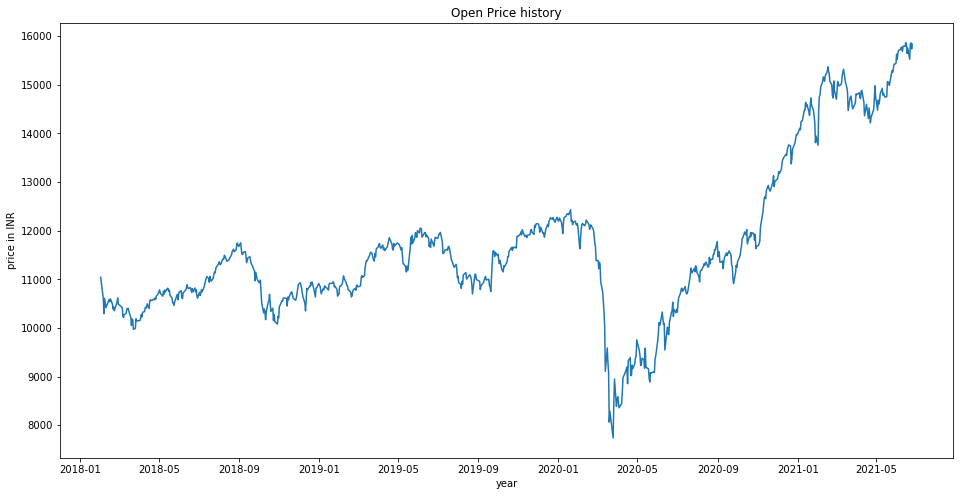

In [4]:
plt.figure(figsize=(16,8))
plt.plot(df[500:]["Open"])
plt.title("Open Price history")
plt.xlabel("year")
plt.ylabel("price in INR")
plt.show()

In [5]:
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Open'])
for i in range(0,len(df)):
    new_dataset["Date"][i]=df['Date'][i]
    new_dataset['Open'][i]=df['Open'][i]
new_dataset.index = new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [6]:
# splitting dataset into train and test data
final_dataset=new_dataset.values
n = len(new_dataset)
train_data=final_dataset[0:int(n*.60),:]
test_data=final_dataset[int(n*.60):,:]
n,len(train_data),len(test_data)

(1340, 804, 536)

In [7]:
# Applying MinMax scaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

In [8]:
# train data
x_train_data,y_train_data=[],[]
time_step = 60
for i in range(time_step,len(train_data)):
    x_train_data.append(scaled_data[i-time_step:i,0])
    y_train_data.append(scaled_data[i,0])
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

print(x_train_data.shape, y_train_data.shape)

(744, 60, 1) (744,)


In [9]:
# test data
inputs_data=new_dataset[len(new_dataset)-len(test_data)-time_step:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

X_test,Y_test=[],[]
for i in range(time_step,inputs_data.shape[0]):
    X_test.append(inputs_data[i-time_step:i,0])
    Y_test.append(inputs_data[i,0],)
X_test,Y_test = np.array(X_test),np.array(Y_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape,Y_test.shape)

(536, 60, 1) (536,)


In [10]:
# lstm model
lstm_model=Sequential()
lstm_model.add(LSTM(units=30,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=30))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [11]:
lstm_model.fit(x_train_data,y_train_data,epochs=5,batch_size=128,verbose=1)

Epoch 1/5
6/6 [==============================] - 5s 54ms/step - loss: 0.0820
Epoch 2/5
6/6 [==============================] - 0s 57ms/step - loss: 0.0088
Epoch 3/5
6/6 [==============================] - 0s 53ms/step - loss: 0.0100
Epoch 4/5
6/6 [==============================] - 0s 55ms/step - loss: 0.0030
Epoch 5/5
6/6 [==============================] - 0s 54ms/step - loss: 0.0046


In [12]:
lstm_model.save("lstm_model.h5")

In [13]:
# improved lstm model
improved_model=Sequential()
improved_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
improved_model.add(Dropout(0.2))
improved_model.add(LSTM(units = 50))
improved_model.add(Dropout(0.2))
improved_model.add(Dense(units = 1))
improved_model.compile(loss='mean_squared_error',optimizer='adam')

improved_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [14]:
improved_model.fit(x_train_data,y_train_data,epochs=30,batch_size=64,verbose=1)

Epoch 1/30
12/12 [==============================] - 4s 57ms/step - loss: 0.0410
Epoch 2/30
12/12 [==============================] - 1s 53ms/step - loss: 0.0064
Epoch 3/30
12/12 [==============================] - 1s 48ms/step - loss: 0.0039
Epoch 4/30
12/12 [==============================] - 1s 48ms/step - loss: 0.0028
Epoch 5/30
12/12 [==============================] - 1s 44ms/step - loss: 0.0021
Epoch 6/30
12/12 [==============================] - 1s 45ms/step - loss: 0.0019
Epoch 7/30
12/12 [==============================] - 1s 49ms/step - loss: 0.0015
Epoch 8/30
12/12 [==============================] - 1s 45ms/step - loss: 0.0014
Epoch 9/30
12/12 [==============================] - 1s 44ms/step - loss: 0.0015
Epoch 10/30
12/12 [==============================] - 1s 45ms/step - loss: 0.0016
Epoch 11/30
12/12 [==============================] - 1s 48ms/step - loss: 0.0014
Epoch 12/30
12/12 [==============================] - 1s 45ms/step - loss: 0.0014
Epoch 13/30
12/12 [==================

In [15]:
improved_model.save("improved_model.h5")

In [16]:
# Calculating test scores
def score(model):

    trainScore = model.evaluate(x_train_data,y_train_data,verbose=0)
    print("Train Score : %8f MSE (%8f RMSE)" % (trainScore, math.sqrt(trainScore)) )

    testScore = model.evaluate(X_test,Y_test,verbose=0)
    print("Test Score : %8f MSE (%8f RMSE)" % (testScore, math.sqrt(testScore)) )

In [17]:
# compraing scores of both models
print("LSTM Model")
score(lstm_model)
print("")
print("Improved Model")
score(improved_model)

LSTM Model
Train Score : 0.003174 MSE (0.056337 RMSE)
Test Score : 0.032477 MSE (0.180214 RMSE)

Improved Model
Train Score : 0.000323 MSE (0.017981 RMSE)
Test Score : 0.001965 MSE (0.044325 RMSE)


In [18]:
# lstm model prediction
# prediction for train data
train_predict = lstm_model.predict(x_train_data)
train_predict = scaler.inverse_transform(train_predict)

# prediction for test data
y_pred = lstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

In [19]:
# improved lstm model prediction
# prediction for train data
train_predict2 = improved_model.predict(x_train_data)
train_predict2 = scaler.inverse_transform(train_predict2)

# prediction for test data
y_pred2 = improved_model.predict(X_test)
y_pred2 = scaler.inverse_transform(y_pred2)

In [20]:
train_data = new_dataset[60:int(n*0.60)]
test_data = new_dataset[int(n*0.60):]
print(len(test_data),len(y_pred))
train_data['predictions'] = train_predict
test_data['predictions'] = y_pred

train_data['improved'] = train_predict2
test_data['improved'] = y_pred2

536 536
C:\Users\91953\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\91953\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\91953\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

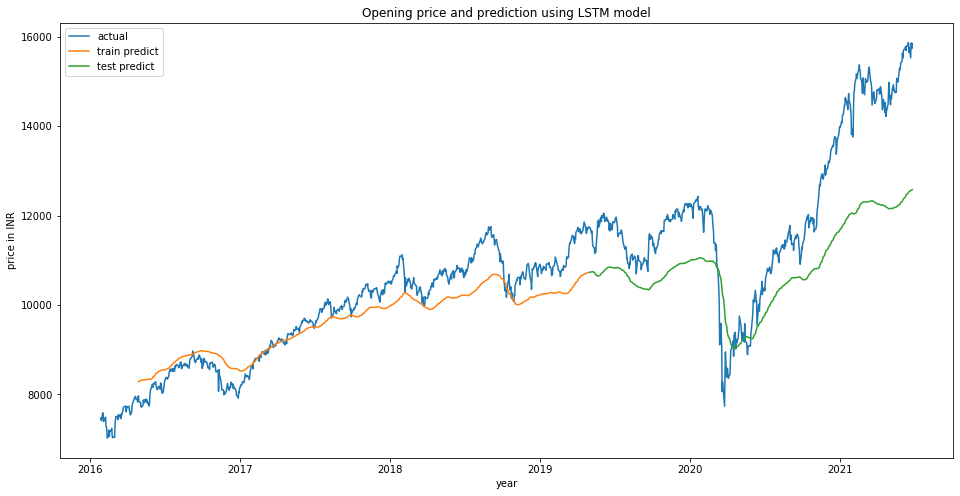

In [21]:
plt.figure(figsize=(16,8))
plt.plot(new_dataset,label='actual')
plt.plot(train_data['predictions'],label = "train predict")
plt.plot(test_data['predictions'],label = "test predict")

plt.title("Opening price and prediction using LSTM model")
plt.xlabel("year")
plt.ylabel("price in INR")
plt.legend()
plt.show()

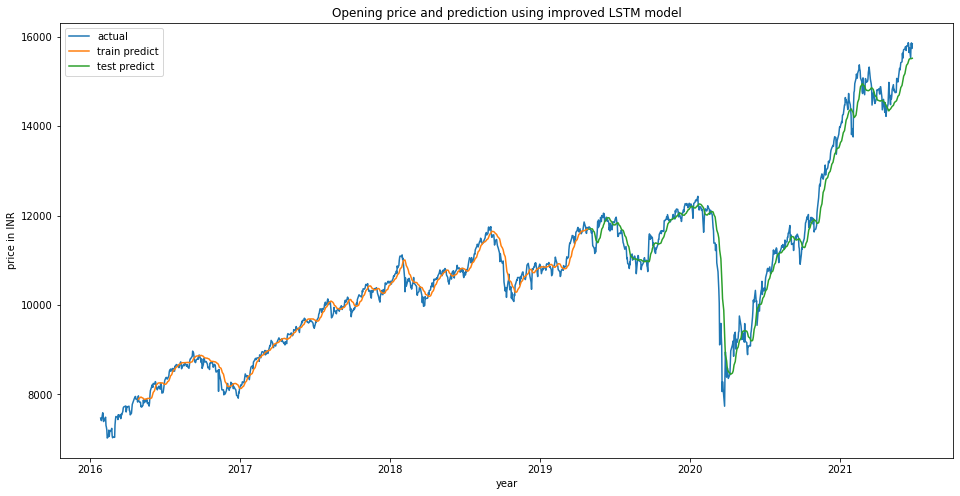

In [22]:
plt.figure(figsize=(16,8))
plt.plot(new_dataset,label='actual')
plt.plot(train_data['improved'],label = "train predict")
plt.plot(test_data['improved'],label = "test predict")

plt.title("Opening price and prediction using improved LSTM model")
plt.xlabel("year")
plt.ylabel("price in INR")
plt.legend()
plt.show()

In [23]:
# forecast for next 30 days
days = 30
for i in range(days):

    new_input = new_dataset.values[-time_step:]
    new_input = scaler.fit_transform(new_input)
    new_input = np.array(new_input)
    new_input = new_input.reshape(1,-1)
    new_input = np.reshape(new_input,(1,time_step,1))

    new_pred = improved_model.predict(new_input)
    new_pred = scaler.inverse_transform(new_pred)

    date = new_dataset.index[-1]+pd.to_timedelta(1,unit='d')
    new_dataset = new_dataset.append(pd.DataFrame({"Open":new_pred[0][0]},index=[date]))
    

predicted_plot = new_dataset[-days:]

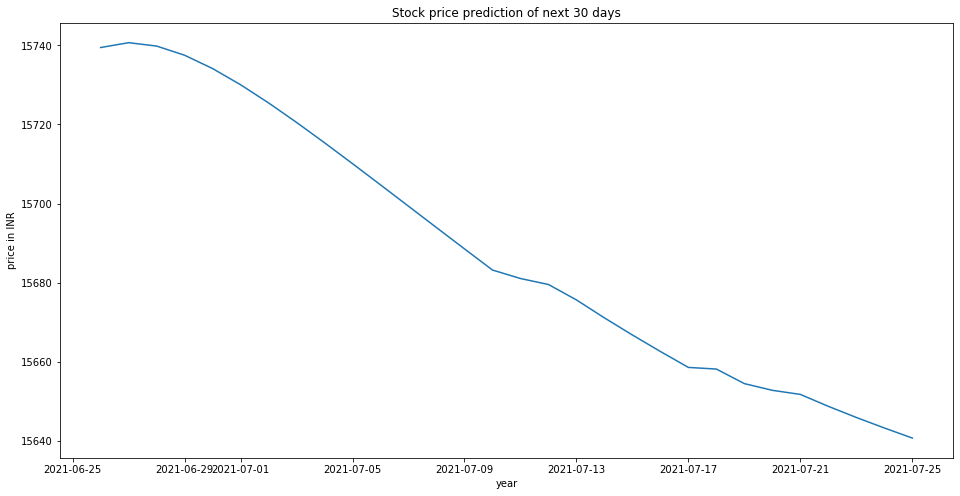

In [24]:
plt.figure(figsize=(16,8))
plt.plot(predicted_plot["Open"])
plt.title("Stock price prediction of next 30 days")
plt.xlabel("year")
plt.ylabel("price in INR")
plt.show()

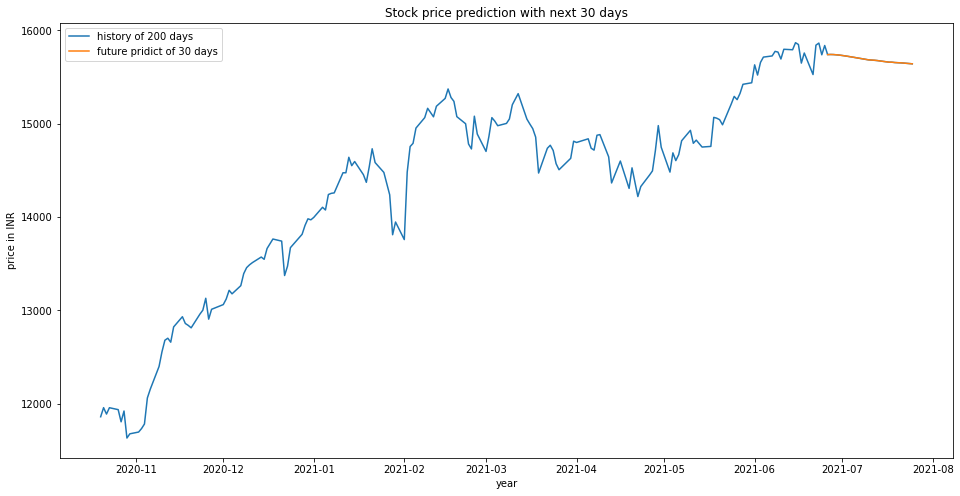

In [25]:
plt.figure(figsize=(16,8))
plt.title("Stock price prediction with next 30 days")
plt.plot(new_dataset[-200:]["Open"],label='history of 200 days')
plt.plot(predicted_plot["Open"],label='future pridict of 30 days')
plt.xlabel("year")
plt.ylabel("price in INR")
plt.legend()
plt.show()

In [ ]:
# delete last row
# new_dataset = new_dataset.head(-days)
# new_dataset.tail()